In [4]:
# Requried libraries 
import pandas
import agentpy as ap
import seaborn as sns
import networkx as nx
import random as random
from math import sqrt 
from itertools import accumulate
from numpy.random import choice
import statistics
import math
from heapq import nlargest
import os
import segregation 
import geopandas as gpd
from libpysal.weights import Kernel
from shapely.geometry import Point
from libpysal import weights
import numpy as np
from scipy.integrate import quad
from segregation.multigroup import MultiDissim, MultiInfoTheory
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re

# setup model

In [ ]:
# ## Define Agent Class: Person

# %%
class Person(ap.Agent):
    
    def setup(self):
        """ Initiate agent attributes. """
        
        # Segregation attributes 
        self.grid = self.model.grid
        self.group = None
        self.random = None
        
        # attributes for reporters
        self.homophily = 0
        
        # grid attributes
        self.coord = None
        
        # NW identifiers
        self.degree = None
        
        # decision threshold 
        self.happy = False


    
    
    def setup_NW(self):
        """ This funciton is only called once in model setup.
        Steps:
        1.  Assign ties to agent (agent.kin), this is an iterator
        2.  Randomly choose a group (race/ethnicity) for one agent of the group, give all connected agents 
            within the clique the same group membership.
        3.  Randomly choose self.p.n_ties_outgroup naby ties of which to change group assignment. This allows
            for a deterministic way of defining homophily.
            
        
        """
        for agent in self.network_caveman.agents:
            agent.kin = agent.network_caveman.neighbors(agent)

            agent.random = self.model.random
            agent.group = self.random.choice(range(self.p.n_groups))

            for kin in agent.kin:
                kin.group=agent.group 
            
            ingroup_members = np.array([])
            
            for n in agent.network_caveman.neighbors(agent):
                if n.group == agent.group:
                    ingroup_members = np.append(ingroup_members, n)
            
            len_ingroup_members=len(ingroup_members)
            len_outgroup_members=self.p.size_cliques-1-len_ingroup_members
  

            while self.p.n_ties_outgroup >len_outgroup_members:

                reassign_group=self.random.choice(ingroup_members)
                if agent.group==1:
                    reassign_group.group=0                
                if agent.group==0:
                    reassign_group.group=1
                
                ingroup_members = np.array([])
                for n in agent.network_caveman.neighbors(agent):
                    if n.group == agent.group:
                        ingroup_members = np.append(ingroup_members, n)
                
                
                
                len_ingroup_members=len(ingroup_members)
                len_outgroup_members=self.p.size_cliques-1-len_ingroup_members

           
            # prepare degree variable
            self.degree=self.network_caveman.graph.degree[self.node]

                    
            self.org_connected = [to for (fr, to) in self.network_caveman.graph.edges(self.node)]
            
   
     
    def find_missing_group(self):
        """ For agents that have a missing degree, find which group is missing
        """
        #    connected to self.node and agent level
        connected_nodes = [to for (fr, to) in G.edges(self.node)]
        connected_agents = [self.model.node_to_agent[node] for node in connected_nodes]
        
        same_group = [agent for agent in connected_agents if agent.group == self.group]
        different_group = [agent for agent in connected_agents if agent.group != self.group]

    def find_available_agents(self, group, G):
        """
        Find a new agent as a function of their group
        
        group = agent.group 0 or 1
        """
        G=self.network_caveman.graph
        #    A, connected to self.node and agent level
        connected_nodes = [to for (fr, to) in G.edges(self.node)]
        connected_agents = [self.model.node_to_agent[node] for node in connected_nodes]
        
        #    B, particular group
        group_agents = [agent for agent in self.grid.agents if agent.group == group]
        
        #    Venn diagram 
        non_friend_group_agents = [agent for agent in group_agents if agent not in connected_agents]
        
        print(f'agents that have group x and are not yet connected{non_friend_group_agents}')

        
        return non_friend_group_agents

    def find_agents_missing_degree(self):
        """
        Find a new agent that has less than degree specified in parameters
        
        degree = model.p.size_cliques -1 
                """
        p_degree = self.model.p.size_cliques -1 
        
        print(f'size cliques is {self.model.p.size_cliques} and degree is {p_degree}')

        agents_missing = [agent for agent in self.grid.agents if agent.degree < p_degree]
        
        return agents_missing
    
    
    def tie_composition(self):
        """
        Find the number of ingroup and outgroup ties per agent
                """
        G=self.network_caveman.graph
        #    A, connected to self.node and agent level
        connected_nodes = [to for (fr, to) in G.edges(self.node)]
        connected_agents = [self.model.node_to_agent[node] for node in connected_nodes]
        
        #    B, particular group
        len_ingroup_ties = len([agent for agent in connected_agents if agent.group == self.group])
        len_outgroup_ties = len([agent for agent in connected_agents if agent.group != self.group])
        
        
        return len_ingroup_ties, len_outgroup_ties




    def drop_random_edges(self):
        """Steps:
        1. Access agent's node and all edges from said node
        2. Choose a random edge from node
        3. Remove self.model.p.n_edges_drop edges
        """
 
        G=self.network_caveman.graph
        print(f'node of {self} is {self.node}')

        for _ in range(self.model.p.n_edges_drop):
            
            agent_ties = G.edges(self.node)

            edges = list(agent_ties) 
            #nonedges = list(nx.non_edges(G))
            #choose a random edge to remove
            if len(edges):
                chosen_edge = random.choice(edges)
            # delete chosen edge
                G.remove_edge(chosen_edge[0], chosen_edge[1])
             #   print(f'edge {chosen_edge} removed from the graph')

        

    def calculate_degree(self,G):
        # update degree variable
        self.degree=G.degree[self.node]
    

    def position(self):
        self.x = self.grid.positions[self][0]
        self.y = self.grid.positions[self][1]

        
# ## Define Model class

class NetworkModel(ap.Model):

    
    def setup(self):  
        ####################################################################
        # Parameters
        s = self.p.size
        self.central_agents = False
        self.count=0
        self.rewired_steps=0

        
        
        self.p.n_cliques=int(self.p.n/self.p.size_cliques)
        print('parameters:  {}'.format(self.p))


        ####################################################################

     
        # caveman graph
        caveman = nx.caveman_graph(
            self.p.n_cliques, 
            self.p.size_cliques)
        
        
       
       ####################################################################
    
        # create grid
        self.grid = ap.Grid(self, (s, s), track_empty=True)

        # Create agents based on Person class
        self.agents = ap.AgentList(self, self.p.n, Person)
        

        # add agents to grid
        self.grid.add_agents(self.agents, random=True, empty=True) 
        
        ####################################################################\
        # networks
        # Setup fully connected caveman graph 
        
        self.network_caveman = self.agents.network_caveman = ap.Network(self, caveman)

        self.network_caveman.add_agents(self.agents, self.network_caveman.nodes)

        self.agents.node = self.network_caveman.nodes
        
        # create a dictionary for nodes - agents
        self.node_to_agent = dict(zip(self.agents.node, self.agents))

        self.agent_to_node = dict(zip(self.agents.id,self.agents.node.label))
        #self.agent_to_node = dict(zip(self.agents,self.agents.node))


   
        ####################################################################\
        # introduce agent network
        self.agents.setup_NW()

        ####################################################################\

 

        self.agents.position()

        
        self.agents.calculate_degree(G=self.network_caveman.graph)


        # control agent poulation
        n_group1 = len(self.agents.select(self.agents.group == 1))
        n_group0 = len(self.agents.select(self.agents.group ==0))

        group_prop= n_group1/self.p.n
        print('group_prop:  {}'.format(group_prop))

        while group_prop!=0.5: # enforce equal group size
            self.agents.setup_NW()

            # control agent poulation
            n_group1 = len(self.agents.select(self.agents.group == 1))
            n_group0 = len(self.agents.select(self.agents.group ==0))

            group_prop= n_group1/self.p.n
            print('group_prop while loop:  {}'.format(group_prop))


        
    
        #call rewire function
        rewired_steps = 0
        # calculate clustering
        clustering=nx.average_clustering(self.network_caveman.graph)
        # while clustering < clustering_threshold, run rewiring 
        while clustering > self.p.clustering_threshold:
            self.rewire_edges(self.p.steps_rewire)
            G = self.network_caveman.graph
            clustering=nx.average_clustering(self.network_caveman.graph)
            rewired_steps = rewired_steps +1

        # check for self loops
        self.network_caveman.graph.remove_edges_from(nx.selfloop_edges(self.network_caveman.graph))

        # Define viz parameters
        color_dict = {0:'Green', 1:'Grey'}
        colors = [color_dict[c] for c in self.agents.group]
        
        nx.draw(self.network_caveman.graph, node_size=30, node_color=colors)
        plt.savefig(f"network_plots/cliquesize{self.p.size_cliques}_cluster{self.p.clustering_threshold}_tiesoutgroup{self.p.n_ties_outgroup}.jpg")
        plt.show()


        G = self.network_caveman.graph
        print('average_clustering:  {}'.format(nx.average_clustering(G)))

        # Define viz parameters
        color_dict = {0:'Green', 1:'Grey'}
        colors = [color_dict[c] for c in self.agents.group]
        nx.draw(G, node_size=50, node_color=colors)
        plt.show()
        
        print(nx.community.modularity(G, nx.community.label_propagation_communities(G)))
        self.rewired_steps= rewired_steps

        
        self.agents.calculate_degree(G=self.network_caveman.graph)


        # Create edgelist 

        d = []
        for agent in self.grid.agents:
            d.append(
            {
             'group': agent.group,
            'node_label':agent.node.label
             }
            )

        d_attributes=pd.DataFrame(d)


        d_attributes.to_csv(f'network_files/attributes_cliquesize{self.p.size_cliques}_cluster{self.p.clustering_threshold}_tiesoutgroup{self.p.n_ties_outgroup}.csv', index=False)



        custom_edgelist = {}
        edgelist_filename = f'network_files/edgelist_cliquesize{self.p.size_cliques}_cluster{self.p.clustering_threshold}_tiesoutgroup{self.p.n_ties_outgroup}.csv'
        edge_1 = []
        edge_2 = []
        for line in nx.generate_edgelist(self.network_caveman.graph, data=False):
            s = re.findall(r'\d+', line)
            edge_1.append(s[0])
            edge_2.append(s[1])

        edge_df = pd.DataFrame({'source' : edge_1, 'target' : edge_2})
        edge_df.to_csv(edgelist_filename, index=False)

        ####################################################################\

        # set up cavemangraph between neighbors
        
        # 1. select p.n/p.clique_size agents 
        # 2. start with one of the selected agents
        # 3. Identify the p.clique_size -1 closest agents that fullfill homophily criteria
        # 4. Add edges between all of them
        # 5. repeat for all agents selected in 3
  

    def rewire_edges(self, m):
        
        G = self.network_caveman.graph
        active_agent = random.choice(self.agents)
        friend = random.choice(active_agent.get_friends(G=self.network_caveman.graph))
        original_friend = friend
        G.remove_edge(active_agent.node, friend.node)
        for i in range(0,m):
            active_agent, new_friend  = active_agent.find_new_friend_like_you(friend)
            #Change focus to new agent
            friend = active_agent
            active_agent = new_friend

            active_agent, ditch_friend = active_agent.ditch_friend_like_you(friend)
            friend = active_agent
            active_agent = ditch_friend
 

    def get_clustering(self):
        # Calculate average percentage of similar neighbors
        G = self.network_caveman.graph
        return nx.average_clustering(G)
    
    def get_ingroup_ties(self):
        # Calculate average percentage of in group ties 
        return round(sum(self.agents.share_ingroup)/ self.p.n,2)
    def get_outgroup_ties(self):
        # Calculate average percentage of out group ties 
        return round(sum(self.agents.share_outgroup)/ self.p.n,2)


    def get_homophily(self):
        return round(sum(self.agents.homophily/ self.p.n,2))
    
    def get_modularity(self):
        G = self.network_caveman.graph
        #print(nx.community.modularity(G, nx.community.label_propagation_communities(G)))

       # communities = list(nx.community.girvan_newman(G))
        return nx.community.modularity(G, nx.community.label_propagation_communities(G))
    


        

    

    def end(self): 
        # Reporters at the end of the simulation
        self.report('clustering', self.get_clustering())
        self.report('modularity', self.get_modularity())
        self.report('rewired_steps', self.rewired_steps)

        self.report('clustering_threshold', self.p.clustering_threshold)
        self.report('n_ties_outgroup', self.p.n_ties_outgroup)
        self.report('size_cliques', self.p.size_cliques)





        









# %%
parameters = {
    'n_groups': 2, # Number of groups (ethnic)
    'size': 30, # Height and length of the grid
    'steps': 0,  # Maximum number of steps
    'size_cliques':5 , # # how large are cliques
    'steps_rewire': 1,  # How many iterations of rewiring
    'n':800, # agent population 
    'n_ties_outgroup':0,  # defines homophily
    'clustering_threshold': 1
}

model = NetworkModel(parameters)
results=model.run()


reporters=results.reporters
reporters.to_csv(f'network_files/reporters_cliquesize{model.p.size_cliques}_cluster{model.p.clustering_threshold}_tiesoutgroup{model.p.n_ties_outgroup}.csv', index=True)




# clique size 5

In [ ]:


data = pd.DataFrame(columns=['i','seed','clustering','modularity','rewired_steps','clustering_threshold',  'n_ties_outgroup',  'size_cliques'])

print(data)


clique_size=5


for ties_outgroup in [0,1,2]:
  for cluster in [1, 0.8, 0.6, 0.4]:
    parameters.update({
        'size_cliques':5,
        'n_ties_outgroup':ap.Values(ties_outgroup),
        'clustering_threshold':ap.Values(cluster)
    })

    model = NetworkModel(parameters)
    results=model.run()
    reporters=results.reporters
    reporters.to_csv(f'network_files/reporters_cliquesize{model.p.size_cliques}_cluster{model.p.clustering_threshold}_tiesoutgroup{model.p.n_ties_outgroup}.csv', index=True)


    dt=pd.read_csv(f'network_files/reporters_cliquesize{clique_size}_cluster{cluster}_tiesoutgroup{ties_outgroup}.csv')
    data=pd.concat([data, dt])

print(data)
data.to_csv(f'reporters_networkcreate{model.p.size_cliques}.csv', index=True)





# clique size 20

In [ ]:

data = pd.DataFrame(columns=['i','seed','clustering','modularity','rewired_steps','clustering_threshold',  'n_ties_outgroup',  'size_cliques'])

print(data)


clique_size=20


for ties_outgroup in [0, 4, 10]:
  for cluster in [1, 0.8, 0.6, 0.4]:
    parameters.update({
        'size_cliques':20,
        'n_ties_outgroup':ap.Values(ties_outgroup),
        'clustering_threshold':ap.Values(cluster)
    })

    model = NetworkModel(parameters)
    results=model.run()
    reporters=results.reporters
    reporters.to_csv(f'network_files/reporters_cliquesize{model.p.size_cliques}_cluster{model.p.clustering_threshold}_tiesoutgroup{model.p.n_ties_outgroup}.csv', index=True)


    dt=pd.read_csv(f'network_files/reporters_cliquesize{clique_size}_cluster{cluster}_tiesoutgroup{ties_outgroup}.csv')
    data=pd.concat([data, dt])

print(data)
data.to_csv(f'reporters_networkcreate{model.p.size_cliques}.csv', index=True)


# clique size 100

In [ ]:
data = pd.DataFrame(columns=['i','seed','clustering','modularity','rewired_steps','clustering_threshold',  'n_ties_outgroup',  'size_cliques'])

print(data)


clique_size=100


for ties_outgroup in [0, 20, 50]:
  for cluster in [1, 0.8, 0.6, 0.4]:
    parameters.update({
        'size_cliques':100,
        'n_ties_outgroup':ap.Values(ties_outgroup),
        'clustering_threshold':ap.Values(cluster)
    })

    model = NetworkModel(parameters)
    results=model.run()
    reporters=results.reporters
    reporters.to_csv(f'network_files/reporters_cliquesize{model.p.size_cliques}_cluster{model.p.clustering_threshold}_tiesoutgroup{model.p.n_ties_outgroup}.csv', index=True)


    dt=pd.read_csv(f'network_files/reporters_cliquesize{clique_size}_cluster{cluster}_tiesoutgroup{ties_outgroup}.csv')
    data=pd.concat([data, dt])

print(data)
data.to_csv(f'reporters_networkcreate{model.p.size_cliques}.csv', index=True)

# clique size 200

In [ ]:
data = pd.DataFrame(columns=['i','seed','clustering','modularity','rewired_steps','clustering_threshold',  'n_ties_outgroup',  'size_cliques'])

print(data)
model = NetworkModel(parameters)


clique_size=200


for ties_outgroup in [0, 40, 100]:
  for cluster in [1, 0.8, 0.6, 0.4]:
    parameters.update({
        'size_cliques':200,
        'n_ties_outgroup':ap.Values(ties_outgroup),
        'clustering_threshold':ap.Values(cluster)
    })

    model = NetworkModel(parameters)
    results=model.run()
    reporters=results.reporters
    reporters.to_csv(f'network_files/reporters_cliquesize{model.p.size_cliques}_cluster{model.p.clustering_threshold}_tiesoutgroup{model.p.n_ties_outgroup}.csv', index=True)


    dt=pd.read_csv(f'network_files/reporters_cliquesize{clique_size}_cluster{cluster}_tiesoutgroup{ties_outgroup}.csv')
    data=pd.concat([data, dt])

print(data)
data.to_csv(f'reporters_networkcreate{model.p.size_cliques}.csv', index=True)

# clique size 400

In [ ]:
data = pd.DataFrame(columns=['i','seed','clustering','modularity','rewired_steps','clustering_threshold',  'n_ties_outgroup',  'size_cliques'])

print(data)
model = NetworkModel(parameters)

parameters_multi = dict(parameters) 

clique_size=400


for ties_outgroup in [0]:
  for cluster in [1]:

        parameters_multi.update({
            'size_cliques':400,
            'n_ties_outgroup':ap.Values(ties_outgroup)
        })

        model = NetworkModel(parameters_multi)
        results=model.run()
        reporters=results.reporters
        reporters.to_csv(f'network_files/reporters_cliquesize{model.p.size_cliques}_cluster{model.p.clustering_threshold}_tiesoutgroup{model.p.n_ties_outgroup}.csv', index=True)


        dt=pd.read_csv(f'network_files/reporters_cliquesize{clique_size}_cluster{cluster}_tiesoutgroup{ties_outgroup}.csv')
        data=pd.concat([data, dt])

print(data)
data.to_csv(f'reporters_networkcreate{model.p.size_cliques}.csv', index=True)

# create a plot of rewiring steps by network configuration

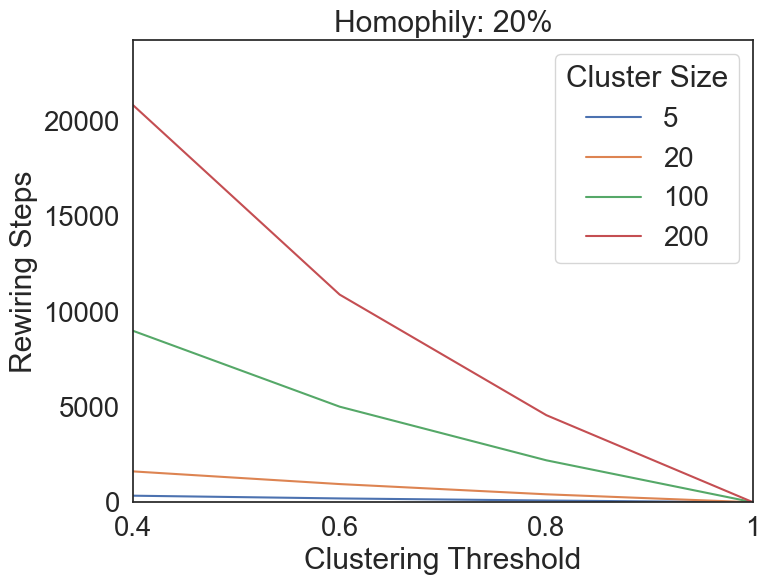

<Figure size 640x480 with 0 Axes>

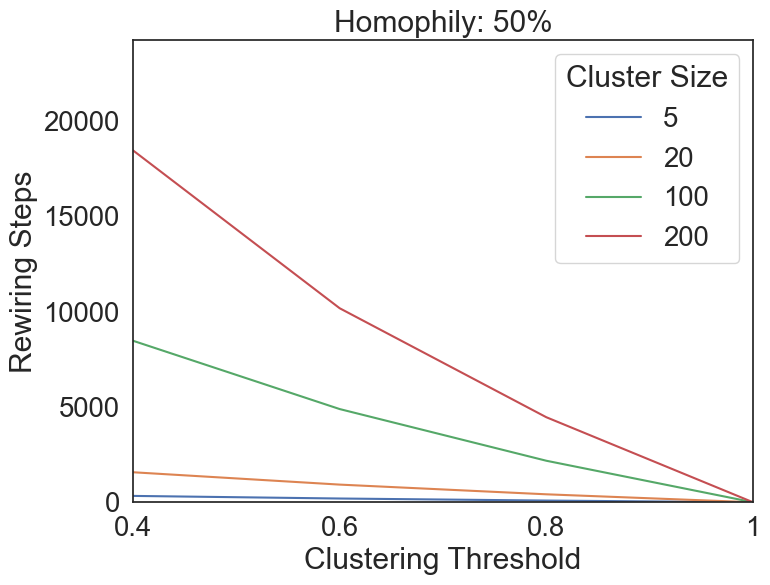

<Figure size 640x480 with 0 Axes>

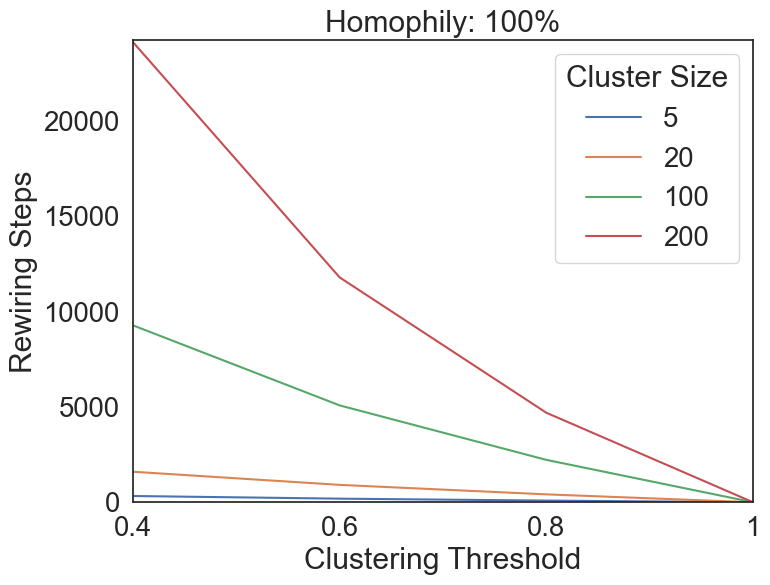

<Figure size 640x480 with 0 Axes>

In [43]:
# Reading the Excel files into separate DataFrames (replace with your actual file paths)
df1 = pd.read_csv('reporters_networkcreate5.csv')
homophily_dict={0:100, 1:20, 2:50}
df1['Homophily'] =df1['n_ties_outgroup'].map(homophily_dict)

df2 = pd.read_csv('reporters_networkcreate20.csv')
homophily_dict={0:100, 4:20, 10:50}
df2['Homophily'] =df2['n_ties_outgroup'].map(homophily_dict)


df3 = pd.read_csv('reporters_networkcreate100.csv')
homophily_dict={0:100, 20:20, 50:50}
df3['Homophily'] =df3['n_ties_outgroup'].map(homophily_dict)

df4 = pd.read_csv('reporters_networkcreate200.csv')
homophily_dict={0:100, 40:20, 100:50}
df4['Homophily'] =df4['n_ties_outgroup'].map(homophily_dict)


# Append the data frames together
df_combined = pd.concat([df1, df2, df3, df4])
homophily_levels = [20, 50, 100]

# Find the min and max values for the x and y axes across the entire dataset
x_min = df_combined['clustering_threshold'].min()
x_max = df_combined['clustering_threshold'].max()
y_min = df_combined['rewired_steps'].min()
y_max = df_combined['rewired_steps'].max() +100

# set seaborn style
sns.set(style="white",font_scale=1.8)

# Loop over each homophily level and create a plot for each
for h_level in homophily_levels:
    # Filter the data for the current homophily level
    df_filtered = df_combined[df_combined['Homophily'] == h_level]
    
    # Create a seaborn lineplot
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_filtered, x='clustering_threshold', y='rewired_steps', hue='size_cliques', palette="deep")
    
    # Set the axis limits for consistent scaling across all plots
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Add titles and labels 
    plt.title(f'Homophily: {h_level}%')
    plt.xlabel('Clustering Threshold')
    plt.ylabel('Rewiring Steps')
    plt.legend(title='Cluster Size')

    
    # set the ticks first   
    plt.xticks([0.4, 0.6, 0.8, 1], ['0.4', '0.6', '0.8', '1']) 


    
    # Show the plot
    plt.show()

    # Save plot
    plt.savefig(f"plot_rewiredsteps{h_level}.jpg")

